# Add phylogenetic information to Abundance data improve sample clustering

coda ande data from paper: Compositionally Aware Phylogenetic Beta-Diversity Measures Better Resolve Microbiomes Associated with Phenotype [mSystems]

github link: https://github.com/cameronmartino/phylo-rclr-benchmarking

In [1]:
import biom
import pandas as pd
import numpy as np
import qiime2 as q2
import skbio
from skbio import TreeNode
from skbio.stats.distance import permanova
from skbio import DistanceMatrix
from biom import Table
from qiime2.plugins.phylogeny.methods import filter_table
from qiime2.plugins.feature_table.methods import rarefy

%matplotlib inline

In [2]:
from rpca import rpca_table,rclr
from preprocessing import fast_unifrac,matrix_rclr

In [3]:
# import data
table = q2.Artifact.import_data('FeatureTable[Frequency]',
                                biom.load_table('/home/wangbin/DeepPhy/data/data_phyloRPCA/urbmerged.biom'))
metadata = q2.Metadata.load('/home/wangbin/DeepPhy/data/data_phyloRPCA/10333_20190808-130957.txt')
tree = q2.Artifact.load('/home/wangbin/DeepPhy/data/data_phyloRPCA/tree.qza')
table = filter_table(table, tree).filtered_table
taxonomy = q2.Artifact.load('/home/wangbin/DeepPhy/data/data_phyloRPCA/taxonomy.qza')

In [4]:
table.view(biom.Table)

210328 x 2226 <class 'biom.table.Table'> with 1312813 nonzero entries (0% dense)

In [5]:
## filter and preprocess data
# remove controls
mf = metadata.to_dataframe()
mf = mf[mf.host_body_site == 'UBERON:skin of hand']
mf = mf[mf.village != 'Puerto Almendras']
mf = mf[mf.house_number.isin([k for k, v in mf.house_number.value_counts().items()
                              if v >= 3])]

# keep shared IDs
bt = table.view(biom.Table)
shared_ = set(bt.ids()) & set(mf.index)
bt = bt.filter(shared_)
mf = mf.reindex(shared_)
metadata = q2.Metadata(mf)

# filter out zero sums
n_features, n_samples = bt.shape
# filter features by N samples presence
min_feature_frequency = 10
def frequency_filter(val, id_, md):
    return (np.sum(val > 0) / n_samples) > (min_feature_frequency / 100)
min_feature_count = 10
def observation_filter(val, id_, md):
        return sum(val) > min_feature_count
bt = bt.filter(observation_filter, axis='observation')
#bt = bt.filter(bt.ids('observation')[(bt.sum('observation') > 0)], axis='observation')
bt = bt.filter(frequency_filter, axis='observation')
bt = bt.filter(bt.ids()[(bt.sum('sample') > 0)])

# re-import
table = q2.Artifact.import_data('FeatureTable[Frequency]', bt)
bt

1443 x 164 <class 'biom.table.Table'> with 60317 nonzero entries (25% dense)

In [6]:
mf

,ac_sampled_room,accult_score,analysis_name,animals_in_house,anonymized_name,carbon_dioxide_inside,cats,cleaning_frequency,closed_trash,collection_date,...,temp_outside_house,title,use_soaps,village,washer,water_source,wind_speed_outside,wireless,years_house_inhabited,zone
sample_name,,,,,,,,,,,,,,,,,,,,,
10333.Man.1810.huma,TRUE,28,Man.1810.huma,8,MG.1076,not provided,3,2,TRUE,9/5/12,...,NaN,Dominguez Sloan SAWesternization gradient,y,Manaus,TRUE,municipal,NaN,TRUE,12,S_o Jos_ I
10333.Manaus.3643.1313501,TRUE,6,Man.3643.huma,0,Manaus.3643,not provided,0,3x week,TRUE,12/14/13,...,NaN,Dominguez Sloan SAWesternization gradient,yes,Manaus,TRUE,municipal,NaN,TRUE,2,NaN
10333.Manaus.3668.1313378,TRUE,6,Man.3668.huma,0,Manaus.3668,not provided,0,3x week,TRUE,12/14/13,...,NaN,Dominguez Sloan SAWesternization gradient,yes,Manaus,TRUE,municipal,NaN,TRUE,2,NaN
10333.Che.103.huma,FALSE,0,Che.103.huma,1,MG.0006,449,0,0,FALSE,7/11/12,...,28,Dominguez Sloan SAWesternization gradient,NaN,Checherta,FALSE,spring,0.54,FALSE,17,Checherta
10333.Che.342.huma,FALSE,0,Che.342.huma,1,MG.0269,not provided,1,not provided,FALSE,7/12/12,...,NaN,Dominguez Sloan SAWesternization gradient,uses lime,Checherta,FALSE,spring,NaN,FALSE,2,Checherta
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10333.Che.437.huma,FALSE,3,Che.437.huma,1,MG.0373,not provided,0,not provided,FALSE,7/12/12,...,NaN,Dominguez Sloan SAWesternization gradient,yes,Checherta,FALSE,spring,NaN,FALSE,0.08,Checherta
10333.Iqu.903.huma,not provided,22,Iqu.903.huma,1,MG.0794,445,1,daily,not provided,7/18/12,...,29,Dominguez Sloan SAWesternization gradient,yes,Iquitos,NaN,municipal,0.39,NaN,0.5,Pampachica
10333.Manaus.3156.1313836,FALSE,2,Man.3156.huma,1,Manaus.3156,not provided,0,daily,FALSE,12/9/13,...,NaN,Dominguez Sloan SAWesternization gradient,yes,Manaus,TRUE,municipal,NaN,FALSE,24,n


In [7]:
bt.ids(axis='observation')

array(['TACGTAGGTGGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGCGCGTAGGCGGTTTCTTAAGTCTGATGTGAAAGCCCACGGCTCAACCGTGGAGGGT',
       'TACAGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGAGTGTAGGTGGCTCATTAAGTCACATGTGAAATCCCCGGGCTTAACCTGGGAACTG',
       'TACAGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGTGGTTCGTTAAGTTGGATGTGAAATCCCCGGGCTCAACCTGGGAACTG',
       ...,
       'TACGTAGGGTGCGAGCGTTGTCCGGAATTATTGGGCGTAAAGGGCGCGTAGGCGGTTTGTCGCGTCGGGAGTGAAAACCAGGTGCTTAACACGTGGCTTG',
       'TACGTAGGGTGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGAGCGCGTAGGCGGTTTGTTGCGTCGGCTGTGAAAACCTGAGGCTCAACCTGAGGCCTG',
       'TACGTAGGGTGCGAGCGTTGTCCGGAATTACTGGGCGTAAAGAGCGCGTAGGCGGTTTGTCGCGTCGTCTGTGAAATTCTGCAACTCAATTGGAGGCGTG'],
      dtype='<U100')

## RPCA with abundance

In [8]:
table_matrix = bt.to_dataframe().T

In [9]:
table_matrix_rclr = rclr(table_matrix)

In [10]:
table_matrix_rclr.shape

(164, 1443)

In [11]:
df_table_abundance_rclr = pd.DataFrame(table_matrix_rclr, index=list(bt.ids(axis='sample')), columns=list(bt.ids(axis='observation')))

In [12]:
df_table_abundance_rclr

,TACGTAGGTGGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGCGCGTAGGCGGTTTCTTAAGTCTGATGTGAAAGCCCACGGCTCAACCGTGGAGGGT,TACAGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGAGTGTAGGTGGCTCATTAAGTCACATGTGAAATCCCCGGGCTTAACCTGGGAACTG,TACAGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGTGGTTCGTTAAGTTGGATGTGAAATCCCCGGGCTCAACCTGGGAACTG,TACGGAGGGTGCAAGCGTTATCCGGATTTATTGGGTTTAAAGGGTCCGTAGGCGGATCTGTAAGTCAGTGGTGAAATCTCACAGCTTAACTGTGAAACTG,TACGTAGGGTGCGAGCGTTGTCCGGAATTATTGGGCGTAAAGAGCTTGTAGGCGGTTTGTCGCGTCTGCTGTGAAAGACCGGGGCTTAACTCCGGTTCTG,TACGTAGGGCGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGAGCTCGTAGGCGGTTTGTCGCGTCTGCTGTGAAAGCCCGGGGCTTAACCCCGGGTGTG,TACGTAGGGTGCGAGCGTTATCCGGAATTATTGGGCGTAAAGAGCTCGTAGGCGGTTTGTCGCGTCTGTCGTGAAAGTCCGGGGCTTAACCCCGGATCTG,TACGTAGGGCGCGAGCGTTATCCGGAATTATTGGGCGTAAAGAGCTCGTAGGCGGTTTGTCGCGTCTGCTGTGAAAGCCCGGGGCTTAACCCCGGGTGTG,TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTCTGTTAAGTCAGATGTGAAATCCCCGGGCTTAACCTGGGAACTG,TACAGAGGGTGCAAGCGTTAATCGGATTTACTGGGCGTAAAGCGCGCGTAGGCGGCTAATTAAGTCAAATGTGAAATCCCCGAGCTTAACTTGGGAATTG,...,TACGTAGGGGGCAAGCGTTGTCCGGATTTACTGGGCGTAAAGAGCGTGTAGGCGGCCACGCAGGTCTGTTGTGAAAACTGGAGGCTCAACCTCCAGACGT,TACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCGCGCAGGCGGTCAGGTAAGTCTGATGTTAAAGCCCGGGGCTCAACCCCGGTTCGC,TACGTAGGGGGCTAGCGTTGTCCGGAATCATTGGGCGTAAAGCGCGCGTAGGCGGCCCGGTCAGTCCGCTCTGAAAGTCCAGGGCTCAACCCTGGAAAGC,TACGTAGGGGGCAAGCGTTGTCCGGATTTATTGGGCGTAAAGCGCGCGCAGGCGGCTTACTAAGTCTGATGTGAAAGCCCACGGCTCAACCGTGGAGGGC,TACGTAGGGGTCGAGCGTTGTCCGGAGTTACTGGGCGTAAAGCGTGCGCAGGCGGCGCATCGCGCTCGGCGTGAAAGCCCCCGGCTCAACCGGGGAGGGG,TACGGAGGGTGCGAGCGTTAATCGGAATCACTGGGCGTAAAGGGCACGCAGGCGGTGACTTAAGTGAGGTGTGAAAGCCCCGGGCTTAACCTGGGAATTG,TACGGAGGGTGCAAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGACTTATAAGTCAGTGGTGAAAGCCTGTCGCTTAACGAGAGAACTG,TACGTAGGGTGCGAGCGTTGTCCGGAATTATTGGGCGTAAAGGGCGCGTAGGCGGTTTGTCGCGTCGGGAGTGAAAACCAGGTGCTTAACACGTGGCTTG,TACGTAGGGTGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGAGCGCGTAGGCGGTTTGTTGCGTCGGCTGTGAAAACCTGAGGCTCAACCTGAGGCCTG,TACGTAGGGTGCGAGCGTTGTCCGGAATTACTGGGCGTAAAGAGCGCGTAGGCGGTTTGTCGCGTCGTCTGTGAAATTCTGCAACTCAATTGGAGGCGTG
10333.Manaus.3346.1313696,1.421567,3.110142,4.201482,1.360942,0.986249,2.006080,3.076990,NaN,NaN,-0.025352,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10333.Manaus.3546.1313272,1.654979,2.925688,3.034206,0.706485,-0.902953,2.647187,2.419464,NaN,-2.202236,3.260182,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10333.Manaus.3708.1313460,NaN,2.576972,3.042268,0.175216,NaN,0.131731,3.212621,NaN,NaN,2.559479,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10333.Manaus.3318.1313403,NaN,3.128366,3.468338,-0.461307,NaN,-0.866772,1.330452,NaN,-1.559919,1.891126,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10333.Manaus.3372.1313934,1.034964,0.271265,4.162011,-1.651522,NaN,0.862943,-0.552910,NaN,NaN,1.736252,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10333.Iqu.1038.huma,3.595911,2.841568,NaN,2.365722,1.762187,3.544377,4.340237,2.695475,-0.001402,2.497298,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.694549,NaN,-1.793161
10333.Iqu.1127.huma,3.603215,1.967460,NaN,1.785138,3.609688,3.879468,4.736919,2.047503,3.257610,2.725146,...,NaN,NaN,NaN,NaN,NaN,NaN,-2.126885,0.175700,NaN,-1.433738
10333.Iqu.1086.huma,4.230214,3.442602,NaN,3.821928,4.703733,2.641683,3.128781,1.248468,1.191310,4.240025,...,NaN,NaN,NaN,NaN,NaN,NaN,-2.335051,-1.236438,NaN,NaN
10333.Man.1810.huma,NaN,2.358093,NaN,-1.363577,NaN,0.987799,2.521418,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
labels_str = [sid.split('.')[1] for sid in df_table_abundance_rclr.index]

In [14]:
set(labels_str)

{'Che', 'Iqu', 'Man', 'Manaus'}

In [15]:
str_dict = {'Che':0, 'Iqu':1, 'Man':2, 'Manaus':2}

labels_int = [str_dict[lab] for lab in labels_str]

In [16]:
# 统计每个类别的样本数
from collections import Counter

Counter(labels_int)

Counter({2: 69, 0: 50, 1: 45})

In [17]:
color_map = {0:'#1f78b4', 1:'#a6cee3', 2:'#ff7f00'}
colors = [color_map[label] for label in labels_int]

In [18]:
feature_loading_abundance_3d, sample_loading_abundance_3d, eigvals_abundance_3d, proportion_explained_abundance_3d, distance_abundance_3d = rpca_table(df_table_abundance_rclr, 3)

In [19]:
sample_loading_abundance_3d

,PC1,PC2,PC3
10333.Manaus.3346.1313696,-0.062700,-0.032890,0.095675
10333.Manaus.3546.1313272,-0.088815,-0.020992,-0.001975
10333.Manaus.3708.1313460,-0.088330,0.158770,0.111032
10333.Manaus.3318.1313403,-0.090491,0.019124,0.080730
10333.Manaus.3372.1313934,-0.051201,-0.064899,0.157518
...,...,...,...
10333.Iqu.1038.huma,0.002337,0.030238,-0.077053
10333.Iqu.1127.huma,0.041955,-0.133582,-0.047127
10333.Iqu.1086.huma,-0.044493,0.046280,-0.106294
10333.Man.1810.huma,-0.053563,-0.047922,0.088778


## Phylo-RPCA

In [20]:
tntree = tree.view(TreeNode)
tntree = tntree.shear(bt.ids('observation'))

In [21]:
counts_by_node, tree_index, branch_lengths, fids, otu_ids = fast_unifrac(bt, tntree)
table_matrix_phylo_rclr = matrix_rclr(counts_by_node, branch_lengths=branch_lengths)

In [22]:
table_matrix_phylo_rclr.shape

(164, 2885)

In [23]:
df_table_phylo_rclr = pd.DataFrame(table_matrix_phylo_rclr, index=list(bt.ids(axis='sample')), columns=fids)

In [24]:
df_table_phylo_rclr

,TACCGGCAGCTCGAGTGATGGCTACTATTATTGGGCCTAAAGCGTCCGTAGCTGGCCGAACAGGTCTGTCGGGAAATCCGCCCGCTTAACGGGCGGACGT,TACCGGCAGCTCGAGTGATGGCCAATATTATTGGGCCTAAAGCGTCCGTAGCTGGCCGAACAGGTCTGTCGGGAAATCCGCTCGCTCAACGAGCGGACGT,TACCGGCAGCACGAGTGATGACCGCTATTATTGGGCCTAAAGCGTCCGTAGCTGGCCGCACAAGTCTATCGGGAAATCTGCGTGCTTAACGCGCAGGCGT,n3,TACCGGCAGCTCGAGTGATAGCCACTATTATTGGGCCTAAAGCGTCCGTAGCCGGCCGAACAGGTCCGTCGGGAAATCCACCCGCTCAACGGGTGGACGT,TACCGGCAGCACGAGTGATAGCCACTATTATTGGGCCTAAAGCGTCCGTAGCCGGCCGAACAGGTCCATCGGGAAATCCACCCGCTCAACGGGTGGACGT,n6,n7,TACCAGCCCCCCGAGTGGTCGGGACGATTATTGGGCCTAAAGCATCCGTAGCCGGCCTTACAAGTCCTCCGTTAAATCCAGCTGCTTAACAGATGGGCTG,TACCAGCACCCCGAGTGGTCGGGACGATTATTGGGCCTAAAGCATCCGTAGCCGGCCTTACAAGTCCTCCGTTAAATCCAGCTGCTTAACAGATGGGCTG,...,n2875,TACGTAGGATGCAAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAACGTAGGCGGTTTCTTAAGTTTGGTCTTAAAGACTGGGGCTCAACCTCAGGAGTG,n2877,n2878,n2879,n2880,n2881,n2882,n2883,n2884
10333.Manaus.3346.1313696,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2.323512,6.166042,0.502780,NaN,7.646263,NaN,8.033234,NaN
10333.Manaus.3546.1313272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.227395,NaN,3.190450,7.341456,1.369719,2.246224,8.820795,NaN,9.208047,NaN
10333.Manaus.3708.1313460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.563252,NaN,2.259085,7.342331,0.438353,4.700673,8.820190,0.516811,9.210433,NaN
10333.Manaus.3318.1313403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.059303,NaN,4.881639,7.390301,3.060908,NaN,8.879754,NaN,9.266725,NaN
10333.Manaus.3372.1313934,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.711612,NaN,5.533948,6.412252,3.713217,NaN,7.951667,NaN,8.338637,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10333.Iqu.1038.huma,NaN,-1.537540,2.084254,-1.518800,NaN,0.953472,-0.627872,1.947267,NaN,NaN,...,7.753710,NaN,10.576837,7.676031,8.756105,NaN,10.494275,4.116036,10.881246,NaN
10333.Iqu.1127.huma,NaN,-0.424388,2.540627,-0.405648,-2.986250,NaN,0.037255,0.303579,NaN,NaN,...,4.037647,NaN,6.952934,7.513244,5.132202,NaN,9.075093,4.160428,9.462064,NaN
10333.Iqu.1086.huma,0.54688,-1.201607,2.484726,0.098067,-2.482535,-1.572796,0.238689,1.030437,NaN,NaN,...,4.050882,NaN,6.901675,7.987754,5.080943,3.301627,9.515733,4.228825,9.903107,NaN
10333.Man.1810.huma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.295200,NaN,5.123058,6.235983,3.302327,NaN,7.762642,NaN,8.149613,NaN


In [25]:
feature_loading_phyloRPCA_3d, sample_loading_phyloRPCA_3d, eigvals_phyloRPCA_3d, proportion_explained_phyloRPCA_3d, distance_phyloRPCA_3d = rpca_table(df_table_phylo_rclr, 3)

In [26]:
import matplotlib.pyplot as plt

def plot_2d(sample_loading, proportion_explained=None):
    fig, ax = plt.subplots()
    if isinstance(sample_loading, pd.DataFrame):
        scatter = ax.scatter(
            sample_loading['PC1'],
            sample_loading['PC2'],
            c=colors,
            cmap='viridis',
            s=8,
            alpha=0.8
        )
        if proportion_explained is not None:
            ax.set_xlabel('PC1: {:.0%}'.format(proportion_explained[0]))
            ax.set_ylabel('PC2: {:.0%}'.format(proportion_explained[1]))
        else:
            ax.set_xlabel('PC1')
            ax.set_ylabel('PC2')
    elif isinstance(sample_loading, np.ndarray):
        scatter = ax.scatter(
            sample_loading[:,0],
            sample_loading[:,1],
            c=colors,
            cmap='viridis',
            s=8,
            alpha=0.8
        )
        if proportion_explained is not None:
            ax.set_xlabel('PC1: {:.0%}'.format(proportion_explained[0]))
            ax.set_ylabel('PC2: {:.0%}'.format(proportion_explained[1]))
        else:
            ax.set_xlabel('PC1')
            ax.set_ylabel('PC2')
    # 创建图例
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', label='Checherta', markerfacecolor='#1f78b4', markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label='Iquitos', markerfacecolor='#a6cee3', markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label='Manaus', markerfacecolor='#ff7f00', markersize=5)
    ]
    ax.legend(handles=legend_elements)
    plt.show()


In [27]:
import matplotlib.pyplot as plt


def normalize_colors(colors):
    normalized_colors = []
    for color in colors:
        normalized_color = tuple(c/255 for c in color)
        normalized_colors.append(normalized_color)
    return normalized_colors

def plot_bar(data_dict, colors=None, rotate=0, label_offset=0, title='Bar Chart', xlabel=None, ylabel='Length',fontsize=15):
    methods = list(data_dict.keys())
    lengths = list(data_dict.values())

    fig, ax = plt.subplots()

    if colors is None:
        colors = 'skyblue'
    elif colors[0][0] > 1:
        colors = normalize_colors(colors)
    ax.bar(methods, lengths, color=colors)
    ax.set_title(title)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.tick_params(axis='x', rotation=rotate)

    for tick in ax.get_xticklabels():
        tick.set_size(fontsize)
        tick.set_ha('right')
        tick.set_rotation(rotate)
        tick.set_position((0,label_offset))

    plt.show()

In [28]:
def plot_box(data_dict, metric='auprc', colors=None, rotate=45, label_offset=0, title='Bar Chart', xlabel=None, ylabel='Length',fontsize=15):
    labels = data_dict.keys()  # 标签
    fig, ax = plt.subplots()
    data = [metric_dict[metric] for metric_dict in data_dict.values()]
    # 绘制箱线图
    boxplot = ax.boxplot(data, patch_artist=True, labels=labels)

    if colors is None:
        colors = 'skyblue'
    elif type(colors[0]) == str:
        colors = [colors]*len(labels)
    elif colors[0][0] > 1:
        colors = normalize_colors(colors)
    # 设置箱线图的颜色
    for patch,color in zip(boxplot['boxes'], colors):
        # r, g, b, a = patch.get_facecolor()
        if type(color) == str:
            patch.set_facecolor(color)
        else:
            patch.set_facecolor((color[0], color[1], color[2], 0.5))

    ax.set_title(title)  # 设置标题
    ax.set_xlabel(xlabel)  # 设置x轴标签
    ax.set_ylabel(ylabel)  # 设置y轴标签

    # 添加散点图
    for (i,dat), color in zip(enumerate(data, 1), colors):
        jitter = np.random.normal(0, 0.04, size=len(dat))
        ax.scatter(np.full(len(dat), i) + jitter, dat, alpha=0.5, color='black', zorder=3)

    for tick in ax.get_xticklabels():
        tick.set_size(fontsize)
        tick.set_ha('right')
        tick.set_rotation(rotate)
        tick.set_position((0,label_offset))
    # # 显示图例
    # ax.legend()

    plt.show()

/tmp/ipykernel_643920/3486924713.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


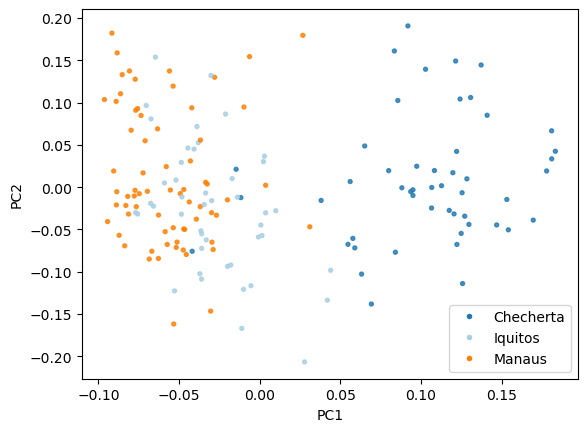

In [29]:
plot_2d(sample_loading_abundance_3d)

/tmp/ipykernel_643920/3486924713.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


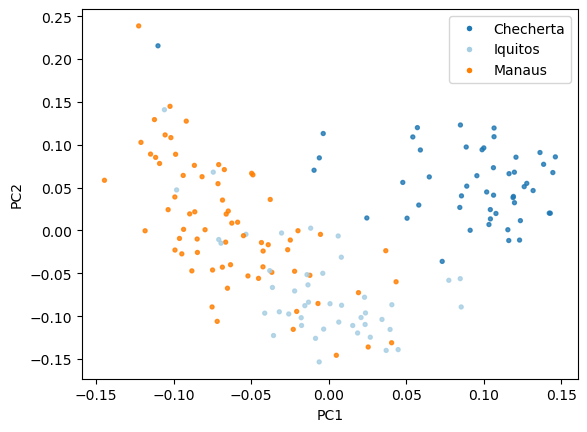

In [30]:
plot_2d(sample_loading_phyloRPCA_3d)

## RPCA with abundance + PCA dimenditon reduction with phylogenetic information

In [32]:
def summary(array):
    print('mean:', array.mean(), 'std:', array.std(), 'min:', array.min(), 'max:', array.max())

In [33]:
def normalize(data, axis=0):
    mean = np.mean(data, axis=axis)
    std = np.std(data, axis=axis)
    normalized_data = (data - mean) / std
    return normalized_data

In [34]:
fid_seq_list = []
for fid in bt.ids('observation'):
    fid_seq_list.append(fid)

In [35]:
distance_matrix = np.zeros((len(fid_seq_list), len(fid_seq_list)))
for node1 in tntree.tips():
    i = fid_seq_list.index(node1.name)
    for node2 in tntree.tips():
        j = fid_seq_list.index(node2.name)
        distance_matrix[i, j] = node1.distance(node2)

In [36]:
import umap.umap_ as umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def reducer(data_matrix, method='pca', n_components=2, whiten=False):
    if method == 'umap':
        reducer = umap.UMAP(n_components=n_components)
    elif method == 'tsne':
        reducer = TSNE(n_components=n_components)
    elif method == 'pca':
        reducer = PCA(n_components=n_components, whiten=whiten)
        embedding = reducer.fit_transform(data_matrix)
        return embedding
    else:
        raise ValueError('Unrecognized method: %s' % method)

    return reducer.fit_transform(data_matrix)


/opt/miniconda/envs/qiime2-tiny-2023.9/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [86]:
otu_evol_embedding = reducer(distance_matrix, 'pca', 200)

In [87]:
otu_evol_embedding.shape

(1443, 200)

In [88]:
summary(otu_evol_embedding)

mean: 3.324360114206775e-17 std: 0.5857400470164771 min: -8.594991691240615 max: 25.795232593126443


In [89]:
# get sample evolutionary feature based on otu embedding

def get_evol_feature(table_matrix_rclr, embeddings):
    evol_feature = []
    for i in range(len(table_matrix_rclr)):
        row = table_matrix_rclr[i]
        idxs = np.where(~np.isnan(row))[0]
        evol_embeds = np.array([embeddings[i] for i in idxs]).sum(axis=0)
        evol_feature.append(evol_embeds)
    return np.array(evol_feature)

In [111]:
evol_feature = get_evol_feature(table_matrix_rclr, otu_evol_embedding)

In [112]:
summary(evol_feature)

mean: 0.043360562289304676 std: 19.91675138707449 min: -629.2013088662483 max: 502.9631403382233


In [116]:
evol_feature_normalized = normalize(evol_feature)

In [117]:
summary(evol_feature_normalized)

mean: 1.5353572072255215e-17 std: 1.0 min: -4.210734842236139 max: 4.247082623569007


### Sample Feature Fusion: Abundance feature + Evolutionary feature

In [168]:
feature_loading_abundance_20d, sample_loading_abundance_20d, eigvals_abundance_20d, proportion_explained_abundance_20d, distance_abundance_20d = rpca_table(df_table_abundance_rclr, 20)

In [169]:
sample_reduced = []
for i, row in sample_loading_abundance_20d.iterrows():
    elements = [v for v in row.values]
    sample_reduced.append(elements)

sample_abundance_feature_20d = np.array(sample_reduced)

In [170]:
sample_abundance_feature_20d.shape

(164, 20)

In [172]:
sample_evol_feature_20d = reducer(evol_feature_normalized, method='pca', n_components=20)

In [173]:
summary(sample_abundance_feature_20d)

mean: 1.4893235696191124e-18 std: 0.07808688094430302 min: -0.3321009263902723 max: 0.47890071884389324


In [174]:
summary(sample_evol_feature_20d)

mean: 1.7330310628295126e-17 std: 2.3274032139915337 min: -7.506036323928815 max: 15.318566552930978


In [175]:
sample_abundance_feature_20d_normalized = normalize(sample_abundance_feature_20d)

In [176]:
summary(sample_abundance_feature_20d_normalized)

mean: 2.166288828536891e-18 std: 1.0 min: -4.252966982086911 max: 6.132921600306693


In [177]:
sample_evol_feature_20d_normalized = normalize(sample_evol_feature_20d)
summary(sample_evol_feature_20d_normalized)

mean: 9.206727521281786e-18 std: 1.0 min: -3.107619347301803 max: 4.320800834526989


In [178]:
# 特征融合
sample_merged_feature = np.concatenate([sample_abundance_feature_20d_normalized, sample_evol_feature_20d_normalized], axis=1)
sample_merged_feature.shape

(164, 40)

In [237]:
sample_merged_feature_2d = reducer(sample_merged_feature, method='pca', n_components=2)

/tmp/ipykernel_623235/3486924713.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


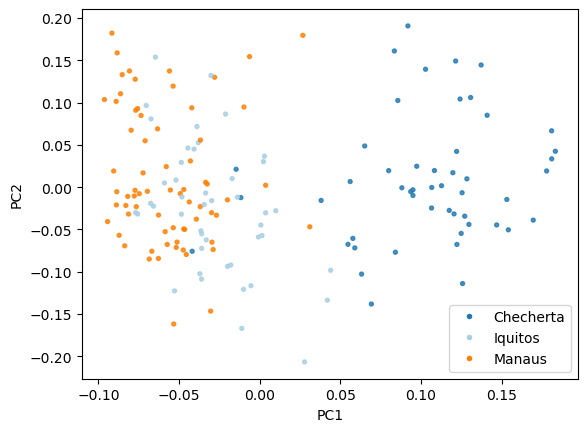

In [238]:
plot_2d(sample_loading_abundance_3d)

/tmp/ipykernel_623235/3486924713.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


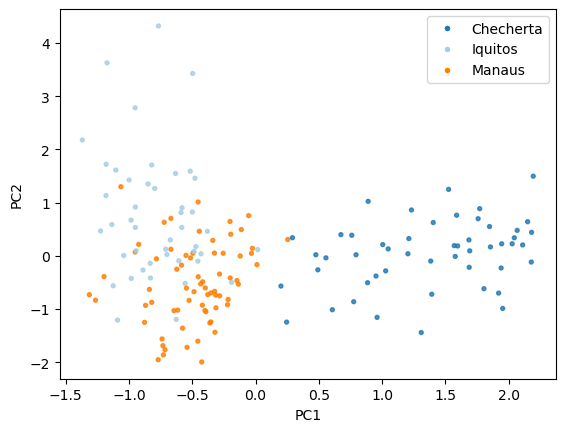

In [239]:
plot_2d(sample_evol_feature_20d_normalized)

/tmp/ipykernel_623235/3486924713.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


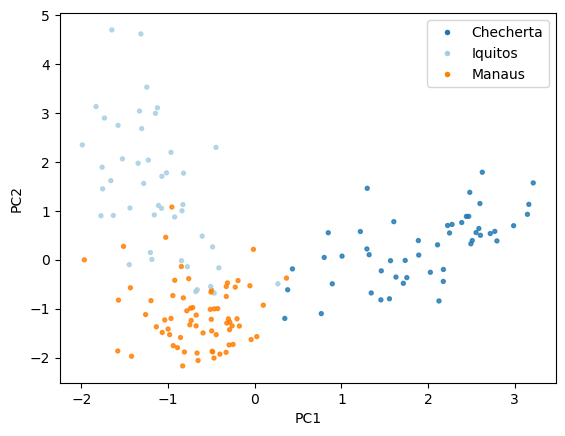

In [240]:
plot_2d(sample_merged_feature_2d)

## Evaluation metrics

In [133]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score, completeness_score, homogeneity_score
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, auc
import numpy as np
import pandas as pd

def get_metrics_auc_aps(sample_loadings_dict, labels_int):
    results = {}
    classes_ = list(set(labels_int))
    y = label_binarize(labels_int, classes=classes_)
    
    # 实例化分层抽样对象
    sss = StratifiedShuffleSplit(n_splits=10, test_size=0.5, random_state=42)
    sss.get_n_splits(list(sample_loadings_dict.values())[0])

    for key, data in sample_loadings_dict.items():
        if isinstance(data, pd.DataFrame):
            X = data.values
        elif isinstance(data, np.ndarray):
            X = data
        else:
            raise ValueError('Unrecognized data type: %s' % type(data))

        roc_auc_scores = []
        aps_auc_scores = []
        auprc_scores = []
        for fold, (train_index, test_index) in enumerate(sss.split(X, y.argmax(1))):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            classifier = KNeighborsClassifier(n_neighbors=40)
            model_tmp = classifier.fit(X_train, y_train)
            y_score = model_tmp.predict_proba(X_test)
            y_score = np.vstack([y_score_class[:, 1] for y_score_class in y_score]).T
            avergage_roc_auc = roc_auc_score(y_test, y_score, average='macro')
            avergage_aps_auc = average_precision_score(y_test, y_score)
            precision = dict()
            recall = dict()
            aupr = dict()
            for i in range(len(classes_)):
                precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])
                aupr[i] = auc(recall[i], precision[i])

            roc_auc_scores.append(avergage_roc_auc)
            aps_auc_scores.append(avergage_aps_auc)
            auprc_scores.append(np.mean([aupr[i] for i in range(len(classes_))]))

        results[key] = {'roc_auc': roc_auc_scores, 'aps': aps_auc_scores, 'auprc': auprc_scores}

    return results

def unsupervised_clustering(sample_loadings_dict, labels_int):
    classes_ = list(set(labels_int))
    n_clusters = len(classes_)

    results = {}
    visuliza_info = {}
    for key, data in sample_loadings_dict.items():
        if isinstance(data, pd.DataFrame):
            X = data.values
        elif isinstance(data, np.ndarray):
            X = data
        else:
            raise ValueError('Unrecognized data type: %s' % type(data))

        # 初始化K-means聚类器
        kmeans = KMeans(n_clusters=n_clusters, random_state=0)
        # 用数据进行聚类
        kmeans.fit(X)
        # 获取预测的标签
        predicted_labels = kmeans.labels_
        ars = adjusted_rand_score(labels_int, predicted_labels)
        ss = silhouette_score(X, predicted_labels)
        cs = completeness_score(labels_int, predicted_labels)
        hs = homogeneity_score(labels_int, predicted_labels)
        results[key] = {'adjusted_rand_score': ars, 
                        'silhouette_score': ss, 
                        'completeness_score': cs, 
                        'homogeneity_score': hs}
        visuliza_info[key] = {'predicted_labels': predicted_labels, 
                        'center': kmeans.cluster_centers_}

    return results, visuliza_info

## permanova 检验

In [184]:
from skbio.stats.distance import permanova
from skbio import DistanceMatrix
from scipy.spatial.distance import cdist

In [216]:
def calculate_permanova(array, labels_int):
    if isinstance(array, pd.DataFrame):
        array = array.values
        distance_matrix = DistanceMatrix(cdist(array, array), ids=list(bt.ids(axis='sample')))
    elif isinstance(array, np.ndarray):
        distance_matrix = DistanceMatrix(cdist(array, array), ids=list(bt.ids(axis='sample')))
    
    return permanova(distance_matrix, labels_int, permutations=999)['test statistic']

In [243]:
permanova_abundance = permanova(DistanceMatrix(distance_abundance_3d), labels_int, permutations=999)['test statistic']
permanova_abundance

65.78419440036852

In [244]:
permanova_phylo_RPCA= permanova(DistanceMatrix(distance_phyloRPCA_3d), labels_int, permutations=999)['test statistic']
permanova_phylo_RPCA

114.49750257035998

In [246]:
permanova_merged_feature = calculate_permanova(sample_merged_feature_2d, labels_int)
permanova_merged_feature

194.29112945773505

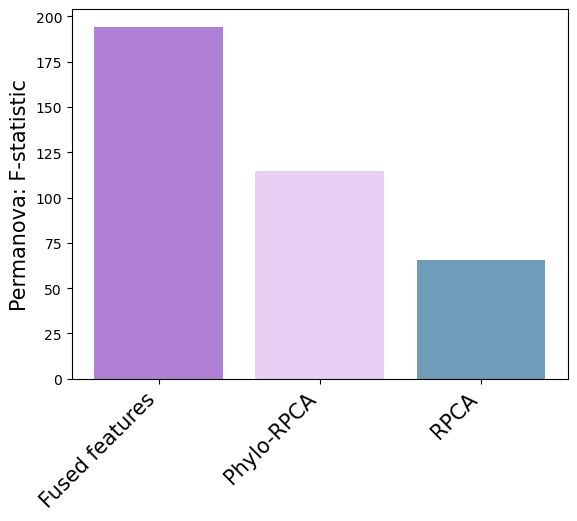

In [247]:
plot_bar({'Fused features':calculate_permanova(sample_merged_feature_2d, labels_int), 
    'Phylo-RPCA':permanova_phylo_RPCA,
    'RPCA':permanova_abundance,
    }, 
    colors=[(175,128,213),(234,207,245),(111,156,185),], rotate=45, title=None, xlabel=None, ylabel='Permanova: F-statistic', label_offset=0) #(64,154,103),(235,140,52),(246,227,86)

## KNN PR-AUC指标

In [248]:
results_all = get_metrics_auc_aps({
    'Fused features': sample_merged_feature_2d,
    'Phylo-RPCA': sample_loading_phyloRPCA_3d,
    'RPCA': sample_loading_abundance_3d,}, labels_int)

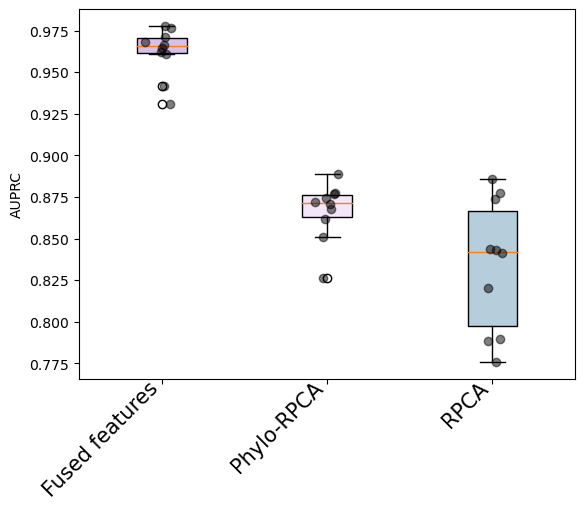

In [249]:
plot_box(results_all,'auprc', 
         colors=[(175,128,213),(234,207,245),(111,156,185),(64,154,103),(235,140,52),(246,227,86)], 
         rotate=45, title=None, xlabel=None, ylabel='AUPRC', label_offset=0.03)

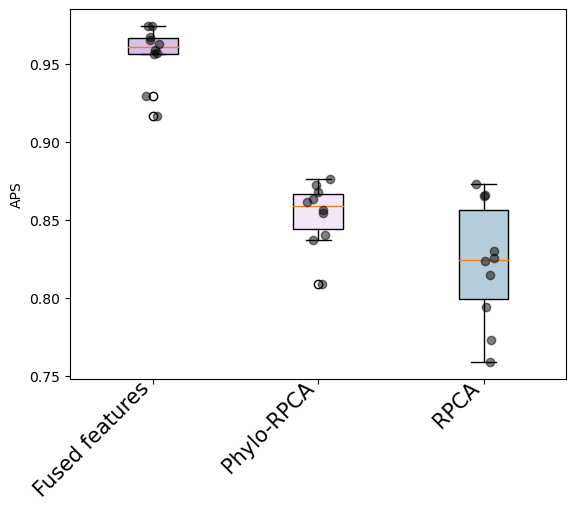

In [250]:
plot_box(results_all,'aps', 
         colors=[(175,128,213),(234,207,245),(111,156,185),(64,154,103),(235,140,52),(246,227,86)], 
         rotate=45, title=None, xlabel=None, ylabel='APS', label_offset=0.03)

In [251]:
results_cluster, visulize_info = unsupervised_clustering({
    'Fused features': sample_merged_feature_2d,
    'Phylo-RPCA': sample_loading_phyloRPCA_3d,
    'RPCA': sample_loading_abundance_3d,
}, labels_int)

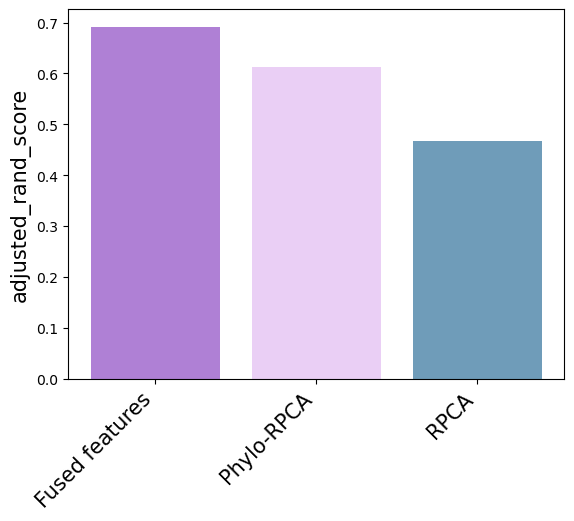

In [252]:
plot_bar({'Fused features':results_cluster['Fused features']['adjusted_rand_score'], 
    'Phylo-RPCA':results_cluster['Phylo-RPCA']['adjusted_rand_score'],
    'RPCA':results_cluster['RPCA']['adjusted_rand_score'],}, 
    colors=[(175,128,213),(234,207,245),(111,156,185),(64,154,103),(235,140,52),(246,227,86)], rotate=45, title=None, xlabel=None, ylabel='adjusted_rand_score', label_offset=0)

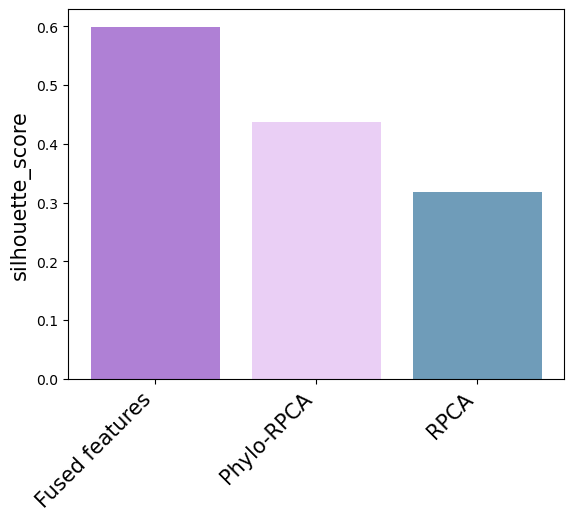

In [253]:
plot_bar({'Fused features':results_cluster['Fused features']['silhouette_score'], 
    'Phylo-RPCA':results_cluster['Phylo-RPCA']['silhouette_score'],
    'RPCA':results_cluster['RPCA']['silhouette_score']}, 
    colors=[(175,128,213),(234,207,245),(111,156,185),(64,154,103),(235,140,52),(246,227,86)], rotate=45, title=None, xlabel=None, ylabel='silhouette_score', label_offset=0)

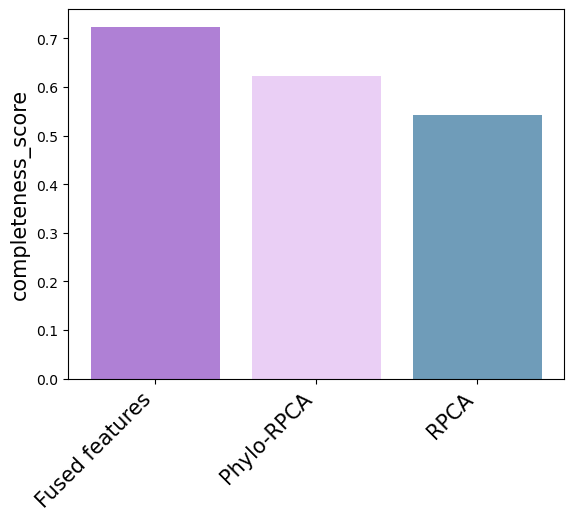

In [254]:
plot_bar({'Fused features':results_cluster['Fused features']['completeness_score'], 
    'Phylo-RPCA':results_cluster['Phylo-RPCA']['completeness_score'],
    'RPCA':results_cluster['RPCA']['completeness_score']}, 
    colors=[(175,128,213),(234,207,245),(111,156,185),(64,154,103),(235,140,52),(246,227,86)], rotate=45, title=None, xlabel=None, ylabel='completeness_score', label_offset=0)

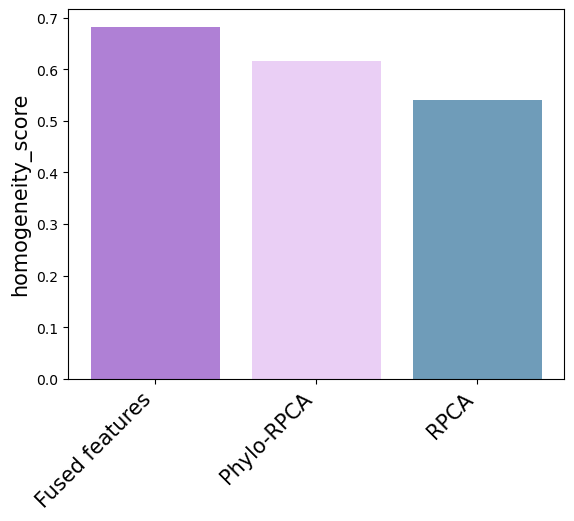

In [255]:
plot_bar({'Fused features':results_cluster['Fused features']['homogeneity_score'], 
    'Phylo-RPCA':results_cluster['Phylo-RPCA']['homogeneity_score'],
    'RPCA':results_cluster['RPCA']['homogeneity_score']}, 
    colors=[(175,128,213),(234,207,245),(111,156,185),(64,154,103),(235,140,52),(246,227,86)], rotate=45, title=None, xlabel=None, ylabel='homogeneity_score', label_offset=0)

In [ ]:
results_cluster

{'abundance+pca+reduced+concat': {'adjusted_rand_score': 0.7202318620792704,
  'silhouette_score': 0.5979830882256415,
  'completeness_score': 0.7606305797041263,
  'homogeneity_score': 0.7174211496904942},
 'abundance+phy2vec+reduced+concat': {'adjusted_rand_score': 0.5517407074128772,
  'silhouette_score': 0.5536157954039016,
  'completeness_score': 0.5727227872807986,
  'homogeneity_score': 0.5453666923234245},
 'phylo-RPCA': {'adjusted_rand_score': 0.6124820650336543,
  'silhouette_score': 0.43672434663303417,
  'completeness_score': 0.6226156217487177,
  'homogeneity_score': 0.6171152034173997},
 'abundance': {'adjusted_rand_score': 0.09099778281443131,
  'silhouette_score': 0.048604844767618345,
  'completeness_score': 0.15778927300840964,
  'homogeneity_score': 0.13202367109208685},
 'abundance+pca+concat': {'adjusted_rand_score': 0.4431076494088572,
  'silhouette_score': 0.3159431684734176,
  'completeness_score': 0.5096598690498892,
  'homogeneity_score': 0.5119931678600467},
